In [14]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


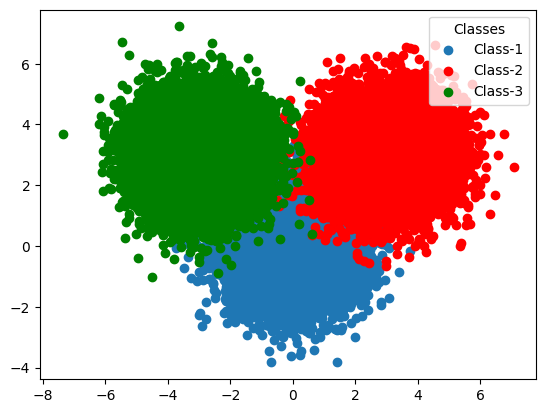

In [15]:
import torch
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
torch.manual_seed(10)

m = 10000

# Generate the data using PyTorch operations
c0 = torch.randn(2, m)
c1 = torch.tensor([[3.], [3.]]) + torch.randn(2, m)
c2 = torch.tensor([[-3.], [3.]]) + torch.randn(2, m)

# Convert tensors to NumPy arrays for plotting
c0_np = c0.numpy()
c1_np = c1.numpy()
c2_np = c2.numpy()

# Plotting the data using matplotlib
plt.scatter(c0_np[0, :], c0_np[1, :], label="Class-1")
plt.scatter(c1_np[0, :], c1_np[1, :], c='r', label="Class-2")
plt.scatter(c2_np[0, :], c2_np[1, :], c='g', label="Class-3")

plt.legend(loc="upper right", title="Classes")
plt.show()


In [16]:
import torch
import torch.nn as nn

n_in = 2          # input size
n_hidden_l = 100  # Example hidden layer size
n_classes = 3     # number of classes

model = nn.Sequential(
    nn.Linear(n_in, n_hidden_l, bias=True),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(n_hidden_l, n_classes),
    nn.LogSoftmax(dim=1)  # Use LogSoftmax with NLLLoss for a more numerically stable solution
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)


Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=100, out_features=3, bias=True)
  (4): LogSoftmax(dim=1)
)

In [17]:
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader

# Step 1: Concatenate the datasets
features = torch.cat((c0, c1, c2), dim=1)  # Concatenate along the second dimension

# Step 2: Create labels for each class
labels_c0 = torch.zeros(m, dtype=torch.long)  # Class 0
labels_c1 = torch.ones(m, dtype=torch.long)   # Class 1
labels_c2 = 2*torch.ones(m, dtype=torch.long)  # Class 2 using torch.full to create all 2s

# Combine the labels
labels = torch.cat((labels_c0, labels_c1, labels_c2), dim=0)

# Step 3: Combine features and labels into a single dataset
dataset = TensorDataset(features.t(), labels)  # Transpose features to match labels shape

# Step 4: Calculate the sizes of train and test sets
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Train set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Train set size: 24000
Test set size: 6000


In [18]:
train_loader = DataLoader(train_dataset, batch_size = 100, shuffle = True)

test_feats, test_labels = test_dataset.dataset.tensors

criterion = nn.NLLLoss()

In [19]:
import time
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Create a writer instance
writer = SummaryWriter('logs/experiment_2')

opt = "adam"
lr = 0.001
num_epoch = 30

# Construct the optimizer (Stochastic Gradient Descent in this case)
if opt == "sgd":
   # L2 regularization is performed if weight_decay parameter is specified
   optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=0.1)
else:
   optimizer = torch.optim.Adam(model.parameters(),lr = lr, betas = (0.9, 0.999))



# Initialize the ExponentialLR scheduler
scheduler = ExponentialLR(optimizer, gamma=0.95)


start = time.time()

# Gradient Descent
iter=0
for epoch in range(num_epoch):

    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Forward pass: Compute predicted y by passing x to the model
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)

        # Compute and print loss
        loss = criterion(y_pred, y_batch)

        # add loss to logs
        writer.add_scalar('Training loss', loss, iter)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Assuming the optimizer has only one param group
        current_lr = scheduler.get_last_lr()[0]
        writer.add_scalar('Learning Rate', current_lr, iter)

        iter = iter+1

        if iter % 100 == 0:

            # Compute predictions
            with torch.no_grad():
                outputs = model(test_feats)
                _, predicted = torch.max(outputs.data, 1)

            # Convert predictions and labels to NumPy arrays
            predicted_np = predicted.cpu().numpy()
            labels_np = test_labels.cpu().numpy()

            # Compute the confusion matrix
            conf_matrix = confusion_matrix(labels_np, predicted_np, normalize = "true")

            print("Confusion Matrix:")
            print(conf_matrix)

            accuracy = accuracy_score(labels_np, predicted_np)

            # Convert to percentage
            accuracy_percentage = accuracy * 100

            print(f"Accuracy: {accuracy_percentage:.2f}%")

    # Step the scheduler at the end of each epoch
    scheduler.step()

end = time.time()

print(f"total time is {end-start}")

writer.close()

Confusion Matrix:
[[0.8275 0.0858 0.0867]
 [0.0078 0.9883 0.0039]
 [0.0087 0.0017 0.9896]]
Accuracy: 93.51%
Confusion Matrix:
[[8.912e-01 4.980e-02 5.900e-02]
 [1.580e-02 9.810e-01 3.200e-03]
 [9.300e-03 6.000e-04 9.901e-01]]
Accuracy: 95.41%
Confusion Matrix:
[[0.927  0.0352 0.0378]
 [0.0169 0.9808 0.0023]
 [0.013  0.001  0.986 ]]
Accuracy: 96.46%
Confusion Matrix:
[[9.401e-01 2.940e-02 3.050e-02]
 [1.760e-02 9.809e-01 1.500e-03]
 [1.590e-02 9.000e-04 9.832e-01]]
Accuracy: 96.81%
Confusion Matrix:
[[9.476e-01 2.690e-02 2.550e-02]
 [1.930e-02 9.793e-01 1.400e-03]
 [1.840e-02 4.000e-04 9.812e-01]]
Accuracy: 96.94%
Confusion Matrix:
[[0.9509 0.0251 0.024 ]
 [0.0206 0.978  0.0014]
 [0.0157 0.0011 0.9832]]
Accuracy: 97.07%
Confusion Matrix:
[[9.461e-01 2.540e-02 2.850e-02]
 [1.990e-02 9.781e-01 2.000e-03]
 [1.410e-02 9.000e-04 9.850e-01]]
Accuracy: 96.97%
Confusion Matrix:
[[9.565e-01 2.180e-02 2.170e-02]
 [2.390e-02 9.750e-01 1.100e-03]
 [1.890e-02 3.000e-04 9.808e-01]]
Accuracy: 97.08%
C

In [20]:
%tensorboard --logdir logs

Output hidden; open in https://colab.research.google.com to view.